In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import heapq
import random

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch import nn

import youtokentome as yttm


def load_war_and_piece_chunks(fname, chunk_size=200):
    with open(fname, 'r', encoding="utf8") as fin:
        full_text = fin.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text), chunk_size // 2)]

def save_texts_to_file(texts, out_file):
    with open(out_file, 'w', encoding="utf8") as outf:
        outf.write('\n'.join(texts))

def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=100, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]

        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part



In [2]:
all_chunks = load_war_and_piece_chunks('war_and_peace.txt')
len(all_chunks)

7976

In [3]:
print(all_chunks[1])

                           
                                   ТОМ 1

                               ЧАСТЬ ПЕРВАЯ
  

                  I.
             

    - Еh bien, mon prince. Genes et Lucques ne


In [4]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print(len(train_texts))
print(len(test_texts))

5583
2393


In [5]:
BPE_MODEL_FILENAME = 'war_and_peace_bpe.yttm'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [6]:
TRAIN_TEXTS_FILENAME = 'war_and_peace_bpe_train.txt'

save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME)

In [7]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)


In [8]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л в р к , д м у п я г ь ы з . б ч й - ж ш e х ю ц s a n r i u o t щ э П l Н ф А В m d О c ? ! К Д Б p М " v Р ) ( С И ; ' Т ё 1 : h Я 2 q ъ f Г Ч b g Э 0 Е 3 [ ] 4 5 I Л j 8 z З 6 M У 7 9 A Ж x V L X Ф Ш y Х C B J P S E D N k R Q Ц T O w ` Ю G F H U K Й Ь W Z * & # / Щ ▁с ▁п ▁в то ▁н ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ро ел ▁б ер ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ▁з ▁е ла ▁т ре ▁у ва ни ся сь ▁что ак ет ру ▁ко ▁бы да ны ми ня ди ▁то хо ▁го ▁за ▁г ем ▁он ки ол ени ви ▁от каз ▁э ну е, ▁П та ти ши ▁при ▁Н му ▁ра ▁вы ▁вс ▁ж ов ле ▁А ▁В ▁мо ▁про ▁во до казал мо ▁как ля ма ▁его ры ▁это ей ▁сказал ▁об сто ль ▁О ▁а ере ▁я ▁до ▁кото ▁К не ▁Д ▁кня ▁сво ▁Б ▁но у, сти ▁ни али м, й, чи по ча ста его си ве тел ▁из лу ала ▁под вори ▁Ан ▁d ▁ка ша ▁М .. ска ... лы я, лся re зь за де жи сть ▁со ско ou ▁хо ▁ру ▁ст ▁ви ▁Пь ень ▁ли ря лю ме ▁так енно га сно ▁Р ты ▁( уд ▁p дел ▁раз те ски ги ку ▁С ше вши ▁ва es со ще ▁c же бе ▁И ▁было on вал ▁сто ту ▁се ▁l ▁гово

In [9]:
print(tokenizer.encode(train_texts[:1]))

[[4, 41, 620, 40, 736, 455, 41, 56, 672, 528, 4, 104, 104, 717, 167, 32, 312, 385, 157, 274, 17, 872, 161, 182, 313, 515, 190, 993, 204, 32, 179, 622, 147, 179, 32, 574, 163, 156, 7, 169, 26, 427, 876, 358, 190, 183, 193, 364, 849, 706, 13, 157, 219, 447, 154, 414, 164, 223, 26, 160, 326, 169, 351, 252, 147, 696, 583, 160, 656, 11, 256, 290, 658, 149, 310, 32, 532, 149, 779, 612, 354]]


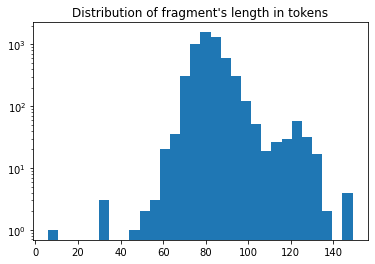

In [10]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True) #begin of seq, end of seq
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title("Distribution of fragment's length in tokens")
plt.yscale('log')

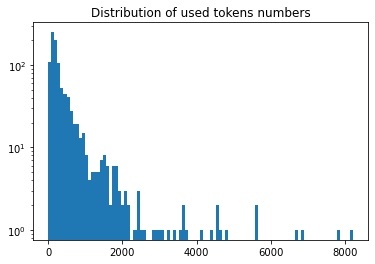

In [11]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Distribution of used tokens numbers')
plt.yscale('log')

In [12]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Number with unknown N-gramms', unknown_subwords_in_test)

Number with unknown N-gramms 0


In [13]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [14]:
train_dataset[0]

(array([ 41, 620,  40, 736, 455,  41,  56, 672, 528,   4, 104, 104, 717,
        167,  32, 312, 385, 157, 274,  17, 872, 161, 182, 313, 515, 190,
        993, 204,  32, 179, 622, 147, 179,  32, 574, 163, 156,   7, 169,
         26, 427, 876, 358, 190, 183, 193, 364, 849, 706,  13, 157, 219,
        447, 154, 414, 164, 223,  26, 160, 326, 169, 351, 252, 147, 696,
        583, 160, 656,  11, 256, 290, 658, 149, 310,  32, 532, 149, 779,
        612, 354]),
 array([620,  40, 736, 455,  41,  56, 672, 528,   4, 104, 104, 717, 167,
         32, 312, 385, 157, 274,  17, 872, 161, 182, 313, 515, 190, 993,
        204,  32, 179, 622, 147, 179,  32, 574, 163, 156,   7, 169,  26,
        427, 876, 358, 190, 183, 193, 364, 849, 706,  13, 157, 219, 447,
        154, 414, 164, 223,  26, 160, 326, 169, 351, 252, 147, 696, 583,
        160, 656,  11, 256, 290, 658, 149, 310,  32, 532, 149, 779, 612,
        354,   3]))

In [15]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> ieur le vicomte 77 совершенно справедливо полагает, что дела зашли уже слишком далеко. Я думаю, что трудно будет возвратиться к старому. - Сколько я слышал, - краснея, опять вмешался в разго',
 'ieur le vicomte 77 совершенно справедливо полагает, что дела зашли уже слишком далеко. Я думаю, что трудно будет возвратиться к старому. - Сколько я слышал, - краснея, опять вмешался в разговор']

In [16]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask
make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [23]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result


torch.Size([30, 30])

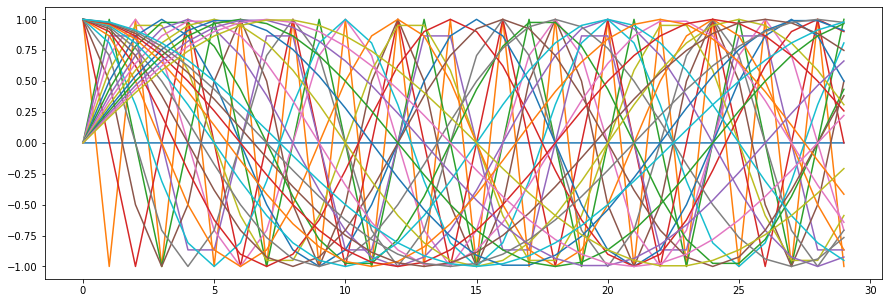

In [29]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:, ::3])
plt.gcf().set_size_inches((15, 5))
sample_pos_codes[:, :].shape

In [25]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0): # backbone is some NN
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        
        batch_size, max_in_length = seed_token_ids.shape
        
        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length)
        
        seed_embs = self.embeddings(seed_token_ids) # batchSize x maxLength x embSize
        pos_codes = make_positional_encoding(max_in_length, self.embedding_size).unsqueeze(0)
        
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)
        
        target_features = seed_embs
        target_features = self.backbone(seed_embs, mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features) # batchSize x targetLen x vocabSize
        

In [49]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

In [61]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                

In [62]:
def get_params_number(model):
    return sum(t.numel() for t in model.parameters())

In [69]:
import torch.nn.modules.TransformerEncoderLayer
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

ModuleNotFoundError: No module named 'torch.nn.modules.TransformerEncoderLayer'

In [64]:
from torch.utils.data import DataLoader
import copy
import datetime
import random
import traceback

def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))
    
def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
                print(batch_x)
                pred = model(batch_x)
                print('pred:', pred)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [65]:
(best_val_loss, best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                                           train_dataset,
                                                           test_dataset,
                                                           lm_cross_entropy,
                                                           lr=2e-3,
                                                           epoch_n=200,
                                                           batch_size=64,
                                                           device=None,
                                                           early_stopping_patience=15,
                                                           max_batches_per_epoch_train=100,
                                                           max_batches_per_epoch_val=100,
                                                           lr_scheduler_ctor=lr_scheduler)

Эпоха 0
tensor([[266, 190, 161,  ..., 182,  13, 534],
        [  7, 495, 170,  ..., 618, 374, 770],
        [  2, 730, 438,  ...,   0,   0,   0],
        ...,
        [983, 403, 189,  ..., 203, 308, 558],
        [  2, 543, 664,  ..., 151,   0,   0],
        [504, 273, 347,  ..., 339, 201, 175]], dtype=torch.int32)
pred: None
Ошибка при обучении: 'NoneType' object has no attribute 'view'
Traceback (most recent call last):
  File "<ipython-input-64-7a4b8717aa2e>", line 86, in train_eval_loop
    loss = criterion(pred, batch_y)
  File "<ipython-input-49-715259c12db7>", line 6, in lm_cross_entropy
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
AttributeError: 'NoneType' object has no attribute 'view'

